# FDL 2019 - Floods

Flooding is a destructive, dangerous, and common hazard. Seventy-five percent of all Presidential disaster declarations are associated with flooding [1]. The work in this memorandum focuses specifically on river flooding. The National Oceanic and Atmospheric Administration's (NOAA's) 13 river forecast centers predict river levels at specific river locations up to several days in advance using hydrologic and hydraulic modeling [1,2]. These forecasts can help cities prepare for and respond to river flooding events in the short-term. The Office of Water Prediction also prepares seasonal water forecasts at regional spatial resolution [3]. The work presented here is complementary to these efforts and explores the efficacy of statistical -- instead of hydrological -- models for the prediction and forecasting of river flooding. 

The scope of this project focuses on two measures of flood susceptibility: predicting whether a specific river gage site will flood in a given month, and the time to peak river level during a flood event. These questions were addressed from two perspectives. The first perspective assumes a well-gaged river basin and seeks to forecast the presence of a flood in the forthcoming month, or the time to peak river level for an ongoing rain event. The second perspective addresses the problem of predicting flood susceptibility in poorly gaged or entirely ungaged river basin. For these experiments, no prior river level information is incorporated into the predictive model. The river level data used to train the statistical models is made possible by the extensive network of stream gages maintained by the US Geological Survey (USGS). Once the models are trained, they are used to construct maps of flood susceptibility, and the most important predictors of flood susceptibility from the statistical models are identified. 


Load in ml library and needed datasets which include:

    -rainfall data from PRISM
    -Landcover information from NLCD
    -Basin Characteristics
    -Threshold Information per site

In [1]:
\l ../../fdl2019/ml/ml.q 
\l ../../fdl2019/ml/init.q
\l ../../fdl2019/ml/fresh/notebooks/graphics.q

\l models.q
\l columns_to_include.q
\l load_data.q

### Cleaning up the Dataset 

All site_no should be updated so that they have at least 8 digits. Any with less will be front loaded with 0's

In [2]:
conv7_fn:{`$$[7=count x;"0",;]x}

In [3]:
gauges:   update conv7_fn each string each site_no from gages
maxht:    update conv7_fn each site_no from max_ht_str
precipall:update conv7_fn each string each site_no from  precipall

delete any nulls or inf values from the dataset 

In [4]:
precip:delete from precipall where ppt=0n
maxht: delete from maxht where height=neg 0w

Add in index column for the warnings table (will be used later for nearest neighbours)

In [5]:
warning:update nn:i from warnings

The NLCD dataset is year dependant, a year column will be added to the dataset and all tables will be joined

Some site_no's have the last few digits excluded from the prism dataset (problem with the prism download side)

In [6]:
rms:asc ds where 12<count each ds:exec distinct string each site_no from gauges 
names:0!select i by site_no from precip where site_no in `$12#'rms
matchnames:0!select i by lat,long from precip where i in names[`x][20]
lst1:til[26]except 21 22
lst2:til[25]except 20
i1:`$rms[lst1],rms[21 22]
i2:(names[`x]lst2),matchnames`x
precip:{![x;enlist(in;`i;z);0b;enlist[`site_no]!enlist enlist y]}/[precip;i1;i2]

## Feature Engineering

Seasonal Information plays an important role when predicting if an area will flood and how long it will take

In [139]:
pi:acos -1
precip:`date xasc update month:`mm$date from precip
precip:update cos_t:cos 2*pi*(month-1)%12,
              sin_t:sin 2*pi*(month-1)%12 from precip
stryear:{$[x<2011;6;x<2016;11;16]}each `year$precip[`date]
precip:update year:stryear from precip

In [1367]:
prev_days:         {![x;();(enlist `site_no)!enlist `site_no;raze {(enlist `$"prev_",string[x],"_",string[y])!
                     enlist (xprev;y;x)}[z]each 1+til y]}
window_feat_month: {![x;();(`date`site_no)!(($;enlist `month;`date);`site_no);raze {(enlist 
                    `$"window_",string[x],"_",string[y])!enlist (max;(mavg;y;x))}[z]each 2+til y]}
upstr:             {![x;();`site_no`date!(((';#);2;($:;`site_no));`date);(enlist `$"upstr_",string[z]
                    ,"_",string[y])!enlist (:':;z)]}
fut_wind:          {[x;y;z;n]dd:"d"$n[1];si:n[0];
                    ?[x;((within;`date;(,;dd;(+;dd;y)));(=;si;`site_no));
                    0b;raze {(enlist `$"fut_",string[x],"_",string[y])!enlist (max;(mavg;y;x))}[z]each 1_til y]}
wind_ht:           {[x;y;z;n]dd:"d"$n[1];si:n[0];
                     ?[x;((within;`date;(,;(+;(-:;2);($;enlist first string `d;dd));($;enlist first string `d;dd)));
                      (=;`si;($;enlist `;`site_no));(within;`datetime;(,;(+;(-:;2);dd);dd)));
                       0b;raze {(enlist `$"wind_",string[x],"_",string[y])!enlist (max;(mavg;y;x))}[z]each raze y]}


Get the previous x days rainfall for each row, and the moving average for each month using multiple window sizes.

Also the previous x stream heights for each site per day

In [1190]:
prev_rain:prev_days[precip;3;`ppt]
prev_height:prev_days[maxht;3;`height]

Knowing the upstream values is also an important feature to include into the dataset. The site_numbers are grouped by the first two digits with the remaining digits in ascending order

In [1191]:
upstr_ppt:upstr[prev_rain;1;`ppt]
upstr_height:upstr[prev_height;1;`height]

In [1192]:
upstr_prev_rain:prev_days[upstr_ppt;3;`upstr_ppt_1]
all_height:prev_days[upstr_height;3;`upstr_height_1]

### Monthly Values

In [1193]:
window_rain:window_feat_month[upstr_prev_rain;5;`upstr_ppt_1]
all_rain:window_feat_month[window_rain;5;`ppt]

## Joining the characteristics tables 

Join the basin characteristics based on site_no.

In [1194]:
stream_char:nlcd ij `site_no xkey basin

## Target Data

### Monthly Target Data

The gage sites are joined to a flood warning level using nearest neighbours

In [1195]:
wlatl:raze each warning[`Latitude`Longitude],'gauges[`dec_lat_va`dec_long_v]
tabw:.ml.clust.kd.buildtree[wlatl;2]
gauge_val:count[warning]+til count gauges
nnwarn:.ml.clust.kd.i.nns[;tabw;(count[warning]#0),count[gauges]#1;flip wlatl;`edist]each gauge_val

In [1196]:
joins:([site_no:gauges`site_no]nn:nnwarn[;0];ndw:nnwarn[;1])
floodlvl:(maxht ij joins)lj`nn xkey warning
floodlvl[`Action`Moderate`Flood`Major]:"F"$'floodlvl[`Action`Moderate`Flood`Major]
floodlvl:update conv7_fn each string each site_no from floodlvl

In [1197]:
show threshold:0!select first Action,first Flood,first Moderate,first Major,no_Action:count where height>Action
              ,no_Flood:count where height>Flood,no_Mod:count where height>Moderate,no_Major:count where 
               height>Major by site_no,"m"$date from floodlvl

site_no  date    Action Flood Moderate Major no_Action no_Flood no_Mod no_Major
-------------------------------------------------------------------------------
01200000 2009.07 6      9     10       12    0         0        0      0       
01200000 2009.08 6      9     10       12    0         0        0      0       
01200000 2009.09 6      9     10       12    0         0        0      0       
01200000 2009.10 6      9     10       12    0         0        0      0       
01200000 2009.11 6      9     10       12    0         0        0      0       
01200000 2009.12 6      9     10       12    0         0        0      0       
01200000 2010.01 6      9     10       12    0         0        0      0       
01200000 2010.02 6      9     10       12    0         0        0      0       
01200000 2010.03 6      9     10       12    1         0        0      0       
01200000 2010.04 6      9     10       12    0         0        0      0       
01200000 2010.05 6      9     10       1

For the sake of this project, we only want to predict if the "Flood" level was reached or not for a site during a given month. Our target data is a binary label of whether this was reaches or not.

Any site that floods more than 28 days per month is omitted from the dataset

In [1198]:
threshold:select from threshold where no_Flood<28
threshold[`target]:threshold[`no_Flood]>0

### Time Peak Target Data

After a major rain event, it is important to know how long to will take for the stream to reach peak height.

The flash Dataset will be used, which highlights how long it will take to reach this peak height, only dates and site numbers used in the dataset above will be extracted.

The time zones have to be updated in order to correspond with the height readings from the stream stats dataset

In [1199]:
peak[`delta_peak]:(peak[`peak_time]-peak[`start_time])*24

To predict how long it will take to flood, we have classified this problem as a binary class of whether or not it will take longer than 3 hours. This is important to know how long people have to evacuate from when a Flood warning is given.

In [1245]:
peak[`target]:peak[`delta_peak]<3.5

## Inputs to the Model

The columns have been divided into three seperate sections:

    -ungaged basin with no perfect forcasts
    -gaged basins with no perfect forcasts
    -gaged basin with perfect forcasts

### Monthly Inputs

This breaks the dataset up per month between the dates of 2009.07-2019.06

In [1246]:
height_data:select from all_height where 1=`dd$date
height_data:update date:"m"$date from height_data

In [1247]:
rain_data:select from all_rain where 1=`dd$date
rain_data:update date:"m"$date from rain_data

Join the stream height and rain data based on site number and month

In [1248]:
height_rain:height_data ij `site_no`date xkey rain_data

This data is then combined with the basin characteristics and Flood threshold dataset by site number and year

In [1249]:
all_monthly_data:(height_rain ij `site_no`year xkey stream_char) ij `site_no`date xkey threshold

#### Lagged features

In [1250]:
cols_fn   :{raze x[`cs]#'x y}
feat_fns  :{raze {x xprev raze y}[z]each ?[x;();();y]}
catch_tgts:0!select site_no,no_Flood,date,cs:count date by site_no from all_monthly_data

In [1251]:
lagy  :feat_fns[catch_tgts;`no_Flood;12]
lag1  :feat_fns[catch_tgts;`no_Flood;1]
lagall:raze{count[x]mavg raze x}each?[catch_tgts;();();`no_Flood]

lagdt:([]site_no:cols_fn[catch_tgts;`site_no];date:cols_fn[catch_tgts;`date];
         lagged_target_1yr:lagy;lagged_target_recent:lag1;lagged_target_all:lagall)
show lagdt:delete from lagdt where i in where any flip null value each lagdt
all_monthly_data:all_monthly_data ij `site_no`date xkey lagdt

site_no  date    lagged_target_1yr lagged_target_recent lagged_target_all
-------------------------------------------------------------------------
01200000 2010.08 0                 0                    0                
01200000 2010.09 0                 0                    0                
01200000 2010.10 0                 0                    0                
01200000 2010.11 0                 0                    0                
01200000 2010.12 0                 0                    0                
01200000 2011.01 0                 0                    0                
01200000 2011.02 0                 0                    0                
01200000 2011.03 0                 0                    0.2              
01200000 2011.04 0                 4                    0.1904762        
01200000 2011.05 0                 0                    0.1818182        
01200000 2011.06 0                 0                    0.173913         
01200000 2011.07 0                 0  

### Time_peak

For the time to peak dataset the day rain and height data is joined to the FLASH dataset based on the site number and date

In [1252]:
all_peak_data:((peak ij `date`site_no xkey upstr_prev_rain) ij 
              `date`site_no xkey all_height) ij 
              `site_no`year xkey stream_char

#### prev window

In [1253]:
time_zone:raze {dd:x[1];
 si:x[0];
 select `$first site_no,`$first unk from str where date=first dd,si=`$site_no}each 
 value each 0!select date by distinct site_no from all_peak_data;
all_peak_data:all_peak_data ij `site_no xkey time_zone
change_zone:{$[y=`EDT;neg[04:00:00.000]+x;y=`CDT;neg[05:00:00.000]+x;neg[06:00:00.000]+x]}

In [1254]:
all_peak_data[`start_time]:change_zone''[all_peak_data`start_time;all_peak_data`unk]
all_peak_data[`peak_time]:change_zone''[all_peak_data`peak_time;all_peak_data`unk]

In [ ]:
wind_ht_prev:wind_ht[str;enlist 2 4 12 48;`height]each value each select site_no,start_time from all_peak_data

In [1256]:
all_peak_data:all_peak_data,'wind_ht_prev
all_peak_data:delete from all_peak_data where wind_2=neg 0w

In [1257]:
rain_pred:raze fut_wind[all_rain;10;`ppt;]each value each select site_no,start_time from all_peak_data
upstr_pred:raze fut_wind[all_rain;10;`upstr_ppt_1;]each value each select site_no,start_time from all_peak_data
all_peak_data:all_peak_data,'rain_pred,'upstr_pred

## Train Test Split

Delete any rows from the dataset that contains a null

In [1258]:
del_null:{where not any each null x}
cleaned_monthly: all_monthly_data[del_null all_monthly_data]
cleaned_peak:    all_peak_data[del_null all_peak_data]

In [1259]:
fnd_col:{x where x in y}
ungaged_noforcast_basinM: fnd_col[ungaged_noforcast_basin;cols cleaned_monthly]
gaged_basinM:             fnd_col[gaged_basin;cols cleaned_monthly]
perfect_forcastM:         fnd_col[perfect_forcast;cols cleaned_monthly]
ungaged_noforcast_basinP: fnd_col[ungaged_noforcast_basin;cols cleaned_peak]
gaged_basinP:             fnd_col[gaged_basin;cols cleaned_peak]
perfect_forcastP:         fnd_col[perfect_forcast;cols cleaned_peak]

In [1260]:
ungage: `M`P!(ungaged_noforcast_basinM;ungaged_noforcast_basinP)
gage:   `M`P!(ungage[`M],gaged_basinM;ungage[`P],gaged_basinP)
forcast:`M`P!(gage[`M],perfect_forcastM;gage[`P],perfect_forcastP)

In [1261]:
split_dict:{(!). flip(
  (`ungaged;flip x[ungage[y]]);
  (`gaged;flip x[gage[y]]);
  (`forcast;flip x[forcast[y]]))}

### Monthly 

Split the train and test up by date, so that only past data is contained in the training set. A date was chosen so that 20 percent of the dataset is in the testing set

In [1262]:
cutoff:update cutoff:min[date]+floor 0.8*max[date]-min[date] by site_no from cleaned_monthly
XtrainM:select from cutoff where date<=cutoff
ytrainM:exec target from cutoff where date<=cutoff
XtestM:select from cutoff where date>cutoff
ytestM:exec target from cutoff where date>cutoff

XtrainM:split_dict[XtrainM;`M]
XtestM:split_dict[XtestM;`M]

### Peak

The time to peak data is seperated so that sites do not appear in both the train and test dataset. To distribution the sum of the target per site is shown below. This distribution is seperated into equeally distributed bins and the train and test split is stratified by this split 

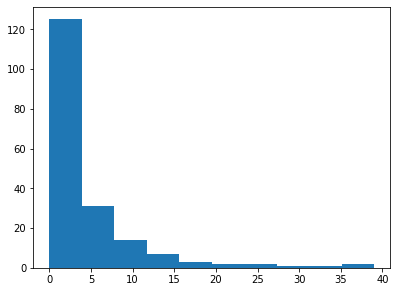

In [1263]:
sites:0!select sum target by site_no from cleaned_peak
plt[`:hist][sites`target];
plt[`:show][];

In [1295]:
bins:0 5 15 25.0
y_binned:bins bin`float$sites`target
tts:train_test_split[sites[`site_no];sites[`target];`test_size pykw 0.2; `random_state pykw 607;
    `shuffle pykw 1b;`stratify pykw y_binned]`;
y_binned2:bins bin `float$tts[2]
tts2:train_test_split[tts[0];tts[2];`test_size pykw 0.25; `random_state pykw 607;
    `shuffle pykw 1b;`stratify pykw y_binned2]`;

In [1296]:
cleaned_peak[`split]:`TRAIN
peak_split:update split:`VALIDATE from cleaned_peak where site_no in `$tts2[1]
peak_split:update split:`TEST from peak_split where site_no in `$tts[1]

In [1297]:
XtrainP:select from peak_split where split=`TRAIN
ytrainP:exec target from peak_split where split=`TRAIN
XtestP:select from  peak_split where split=`TEST
ytestP:exec target from peak_split where split=`TEST

XtrainP:split_dict[XtrainP;`P]
XtestP:split_dict[XtestP;`P]

## Run Models

Gradient Boosts and Random forests were applied to the train and test datasets and the results were printed as a precision/recall curve. This metric was chosen as getting a balance between precision and recall when predicting floods is pivitol to ensure that all floods are given warnings but also not too many false warnings are given. The inputs to the pr_curve are

    -Xtest
    -ytest
    -dictionary of models that are being used


In [1298]:
build_model:{[Xtrain;ytrain;x;y]
 rf_clf:      RandomForestClassifier[`n_estimators pykw x;`random_state pykw 0][`:fit][Xtrain; ytrain];
 xgboost_clf: XGBClassifier[`n_estimators pykw y;`learning_rate pykw 0.3;`random_state pykw 0
              ][`:fit][np[`:array]Xtrain; ytrain];

 `random_forest`GBDT!(rf_clf;xgboost_clf)}

## Perfect Forcast

### Monthly Predicts

"Accuracy for random_forest: 0.9500427"
class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.9510129 0.9978012 0.9738454 10915  
1        | 0.9069767 0.2943396 0.4444444 795    
avg/total| 0.9289948 0.6460704 0.7091449 11710  
"Accuracy for GBDT: 0.953544"
class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.9579617 0.99377   0.9755374 10915  
1        | 0.8242894 0.4012579 0.5397631 795    
avg/total| 0.8911255 0.697514  0.7576502 11710  


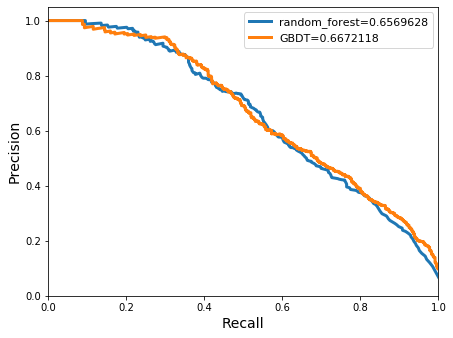

In [1336]:
pr_curve[XtestM`forcast;ytestM;build_model[XtrainM`forcast;ytrainM;500;400]]

### Peak Predictions

"Accuracy for random_forest: 0.7332123"
class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.7468354 0.9291339 0.8280702 381    
1        | 0.6493506 0.2941176 0.4048583 170    
avg/total| 0.698093  0.6116258 0.6164642 551    
"Accuracy for GBDT: 0.7477314"
class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.7574468 0.9343832 0.8366627 381    
1        | 0.691358  0.3294118 0.4462151 170    
avg/total| 0.7244024 0.6318975 0.6414389 551    


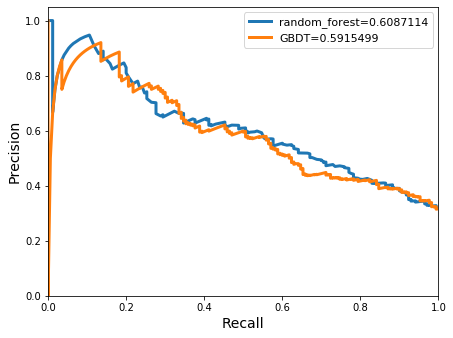

In [1335]:
pr_curve[XtestP`forcast;ytestP;build_model[XtrainP`forcast;ytrainP;400;50]]

## Gaged Prediction

### Monthly Predicts

In [ ]:
pr_curve[XtestM`gaged;ytestM;build_model[XtrainM`gaged;ytrainM;500;400]]

### Peak Predictions

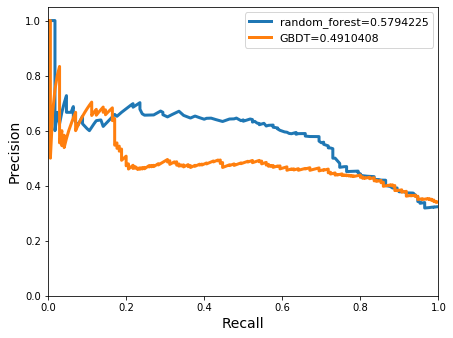

In [1301]:
pr_curve[XtestP`gaged;ytestP;build_model[XtrainP`gaged;ytrainP;400;50]]

## Ungaged Prediction 

### Monthly Predictions

In [ ]:
pr_curve[XtestM`ungaged;ytestM;build_model[XtrainM`ungaged;ytrainM;500;400]]

### Peak Prediction

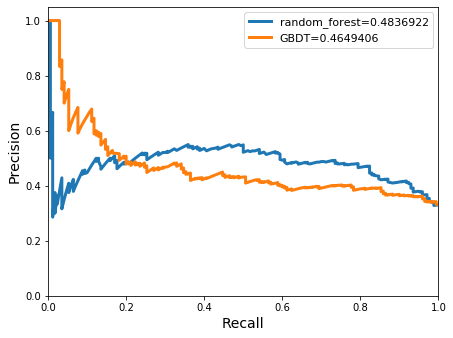

In [1302]:
pr_curve[XtestP`ungaged;ytestP;build_model[XtrainP`ungaged;ytrainP;400;50]]